# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import QNetwork, ReplayMemory
from agents import SnakeDQNAgent

# NN training

In [3]:
aa = SnakeDQNAgent(model_name="baseline_dqn")

In [4]:
aa.set_parameters(max_episode_length=400, replay_memory_size=50000, replay_start_size=10000)

In [ ]:
aa.train(gpu_id=2, batch_size=64, from_epoch=0)

# Visualization

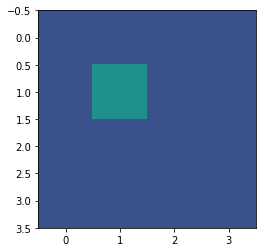

13

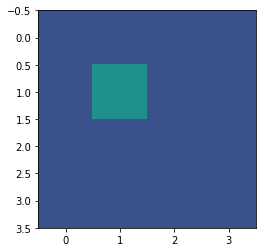

In [6]:
aa.play(gpu_id=2, max_episode_length=100, from_epoch=234)